<a href="https://colab.research.google.com/github/pranay8297/DiffEdit/blob/master/DiffEditMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uq diffusers transformers fastcore ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 21.5 MB/s eta 0:00:00


In [2]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline

from fastcore.all import concat

from huggingface_hub import notebook_login
from PIL import Image

from ipdb import set_trace as st
from tqdm.auto import tqdm

from diffusers import StableDiffusionImg2ImgPipeline
from fastdownload import FastDownload

from diffusers import AutoencoderKL, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import LMSDiscreteScheduler
from torchvision import transforms

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# Setup and Helper Functions

In [3]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

# Here we use a different VAE to the original release, which has been fine-tuned for more steps
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

beta_start, beta_end = 0.00085, 0.012
scheduler = LMSDiscreteScheduler(beta_start = beta_start, beta_end = beta_end, beta_schedule = "scaled_linear", num_train_timesteps = 1000)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [10]:
#Helper Functions

def img_to_latents(im_tensor):
  im_tensor = im_tensor.to(torch.float16).to(vae.device)*2-1
  with torch.no_grad():
    latents = vae.encode(im_tensor[None, :]).latent_dist.sample()
  return latents

def visualize_latents(latents):
  # visualizing the latents.
  fig, axs = plt.subplots(1, latents.shape[1], figsize=(20, 5))

  for i in range(latents.shape[1]):
      axs[i].imshow(latents[0][i].to('cpu').detach().numpy(), cmap='gray')
      axs[i].axis('off')  # Hide axes for better visualization
      axs[i].set_title(f"Channel {i + 1}")

  plt.tight_layout()
  plt.show()

def encode_text(inputs = ['']):

  uncond_inputs = [''] * len(inputs)
  all_inputs = uncond_inputs + inputs
  all_inputs_tokenized = tokenizer(all_inputs, padding = 'max_length', max_length = tokenizer.model_max_length, truncation=True, return_tensors="pt").input_ids.to('cuda')
  with torch.no_grad():
    embeddings = text_encoder(all_inputs_tokenized)[0].half()

  return embeddings

def get_noise(im_latents, prompt, strength = 0.5, seed = 100, guidance_scale = 7.5, num_timesteps = 50):

  torch.manual_seed(seed)
  p_embs = encode_text([prompt])

  #scale the embeddings
  scaled_latents = im_latents.clone() * vae.config.scaling_factor

  # Get the timestep
  scheduler.set_timesteps(num_timesteps)
  start_timestep_index = int(num_timesteps * strength)

  # Generate Noise and add the noise to the scaled latents
  noise = torch.randn_like(scaled_latents, dtype = scaled_latents.dtype, device = scaled_latents.device)
  noisy_latents = scheduler.add_noise(scaled_latents, noise, torch.tensor([scheduler.timesteps[start_timestep_index]], device = scaled_latents.device))

  # Run the diffusion process once on that timestep and get the results

  ts = scheduler.timesteps[start_timestep_index]
  input = torch.cat([noisy_latents]*2, dim = 0)
  input = scheduler.scale_model_input(input, ts)

  with torch.no_grad():
      noise_pred = unet(input, ts, encoder_hidden_states = p_embs).sample

  u, p = noise_pred.chunk(2)
  pred = u + guidance_scale * (p - u)
  noisy_latents = scheduler.step(pred, ts, noisy_latents).prev_sample

  return pred

def get_mask(im_latents, ref, query, n = 10, threshold = 0.1):

  # step - 1

  seeds = torch.randint(low = 0, high = 7*10**6, size = (10,))
  noise_diffs = []
  for i, sd in enumerate(tqdm(seeds)):
    ref_noise = get_noise(latents, 'Horse', strength = 0.5, seed = sd, guidance_scale = 7.5, num_timesteps = 50)
    query_noise = get_noise(latents, 'Zebra', strength = 0.5, seed = sd, guidance_scale = 7.5, num_timesteps = 50)

    ## Calculate Eucledian distance between two noises and then average it on axis 0

    noise_diff = (query_noise - ref_noise)[0].pow(2).sum(dim = 0).pow(0.5)
    noise_diffs.append(noise_diff[None, :])

  noise_diff_t = torch.cat(noise_diffs, dim = 0)
  noise_diff_mean = torch.mean(noise_diff_t, dim = 0)
  # Normalization
  normalized_difference = (noise_diff_mean - noise_diff_mean.min()) / (noise_diff_mean.max() - noise_diff_mean.min())
  # Masking
  mask = (normalized_difference > threshold).float()
  return mask

def edit_image(image_latents, mask, query_text, strength = 0.5, num_timesteps = 50):

  #step 2 and 3

  mask = mask.to(torch.float16)
  embs = encode_text([query_text])

  scaled_latents = image_latents.clone() * vae.config.scaling_factor

  scheduler.set_timesteps(num_timesteps)
  start_timestep_index = int(num_timesteps * strength)

  # Generate Noise and add the noise to the scaled latents
  noise = torch.randn_like(scaled_latents, dtype = scaled_latents.dtype, device = scaled_latents.device)

  yt = None

  for i, ts in enumerate(tqdm(scheduler.timesteps[start_timestep_index:])):

    xt = scheduler.add_noise(scaled_latents, noise, torch.tensor([ts], device = scaled_latents.device))

    if yt == None:
      yt = xt.clone()

    input = torch.cat([yt]*2, dim = 0)
    input = scheduler.scale_model_input(input, ts)

    with torch.no_grad():
      pred = unet(input, ts, encoder_hidden_states=embs).sample

    n_u, n_t = pred.chunk(2)
    noise = n_u + 7.5 * (n_t - n_u)

    yt_hat = scheduler.step(noise, ts, yt).prev_sample
    yt = mask * yt_hat + (1 - mask) * xt

  return yt

def decode_and_visualize(yt):
  with torch.no_grad():
    image = vae.decode(1 / 0.18215 * yt).sample

  image = (image / 2 + 0.5).clamp(0, 1)
  image = image[0].detach().cpu().permute(1, 2, 0).numpy()
  image = (image * 255).round().astype("uint8")
  return Image.fromarray(image)

# Implementation

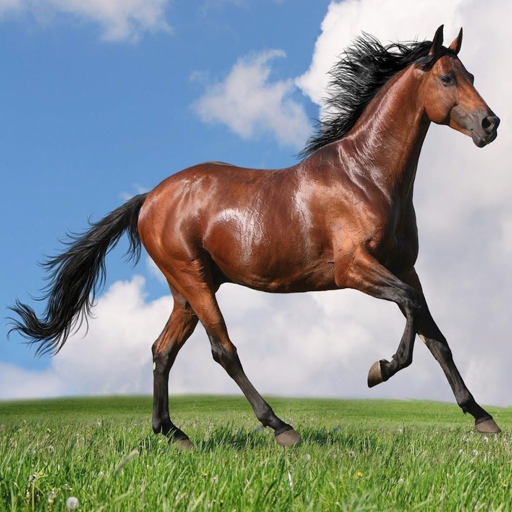

In [5]:
p = FastDownload().download('https://iadsb.tmgrup.com.tr/7ddb86/0/0/0/0/1926/1086?u=https://idsb.tmgrup.com.tr/2018/05/22/horses-the-wings-of-mankind-1527015927739.jpg')
img = Image.open('/root/.fastdownload/archive/horses-the-wings-of-mankind-1527015927739.jpg').crop((0, 0, 1200, 1086)).resize((512, 512))
img

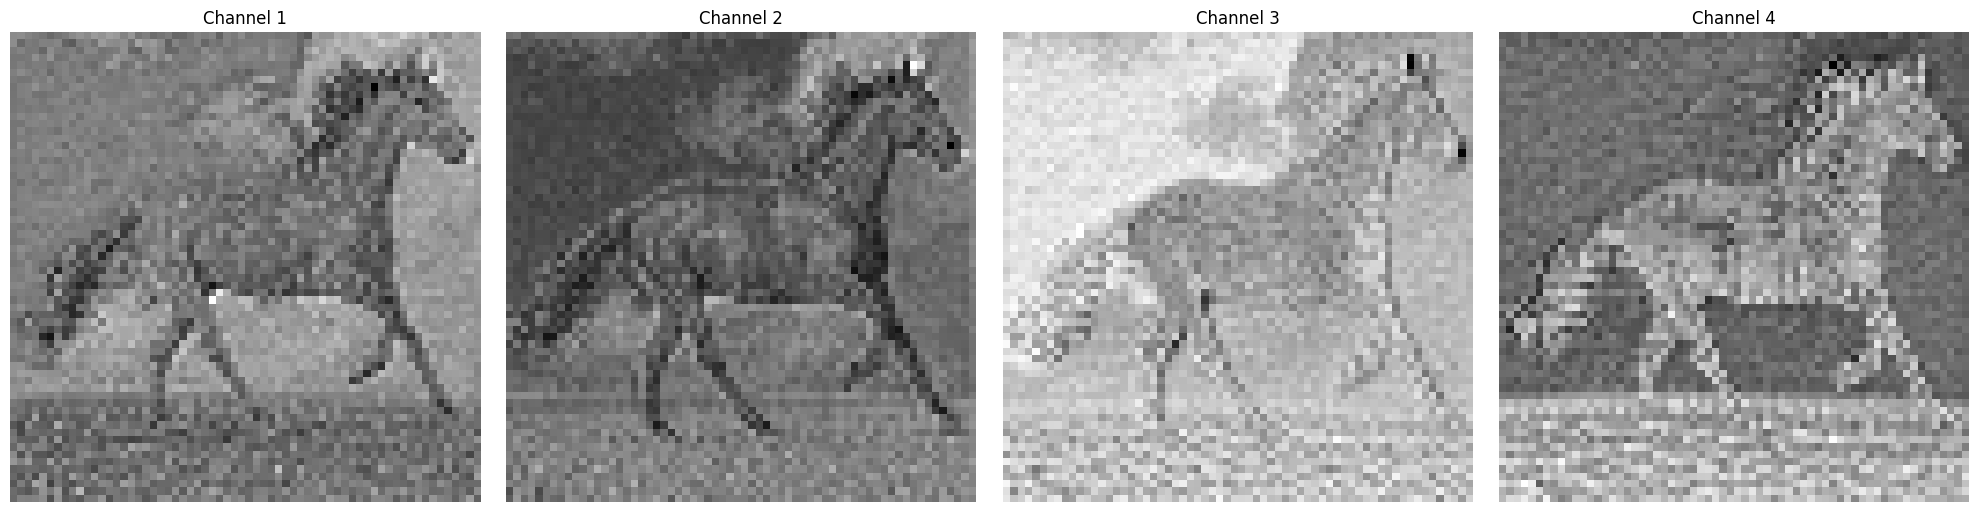

In [6]:
im_tensor = transforms.ToTensor()(img)
im_tensor = im_tensor.to(device).to(torch.float16)
latents = img_to_latents(im_tensor)
visualize_latents(latents)

  0%|          | 0/10 [00:00<?, ?it/s]

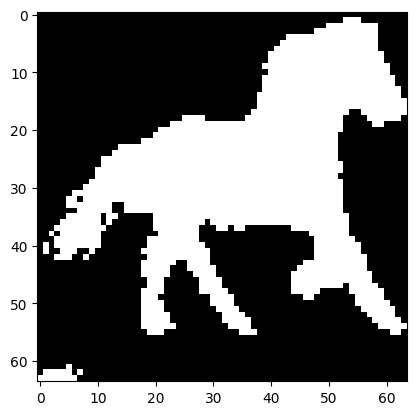

In [11]:
# Generate a mask
mask = get_mask(latents, 'A horse on a grass field with a cloudy sky', 'A zebra on a grass field with a cloudy sky')
plt.imshow(mask.cpu().detach().numpy(), cmap = 'gray')

  0%|          | 0/53 [00:00<?, ?it/s]

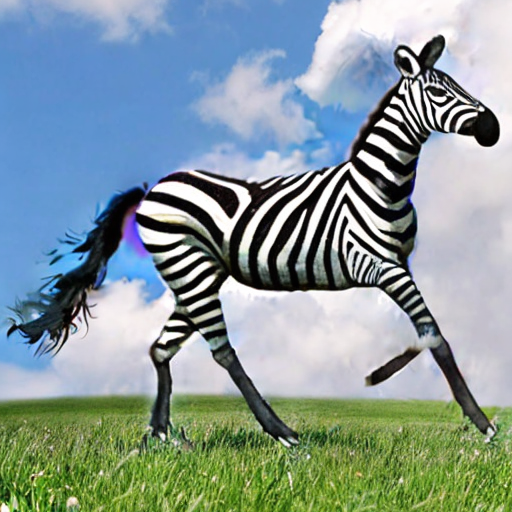

In [12]:
# Edit image
yt = edit_image(latents, mask, 'A zebra on a grass field with a cloudy sky', strength = 0.25, num_timesteps = 70)
decode_and_visualize(yt)

  0%|          | 0/46 [00:00<?, ?it/s]

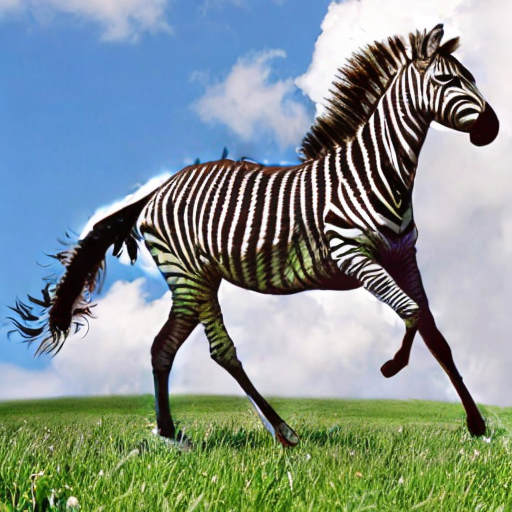

In [13]:
# Edit image
yt = edit_image(latents, mask, 'A zebra on a grass field with a cloudy sky', strength = 0.35, num_timesteps = 70)
decode_and_visualize(yt)

  0%|          | 0/49 [00:00<?, ?it/s]

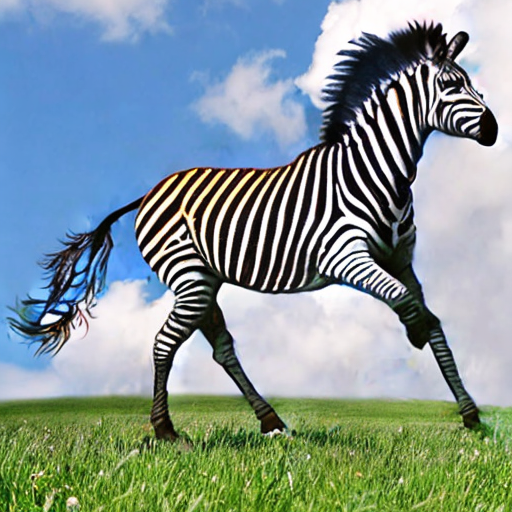

In [14]:
# Edit image
yt = edit_image(latents, mask, 'A zebra on a grass field with a cloudy sky', strength = 0.3, num_timesteps = 70)
decode_and_visualize(yt)

In [18]:

p = FastDownload().download('https://cdn.seniorsguide.com/wp-content/uploads/2022/01/04073609/premium-health-oranges-20211229.jpg')
oranges = Image.open('/root/.fastdownload/archive/premium-health-oranges-20211229.jpg').resize((512, 512))

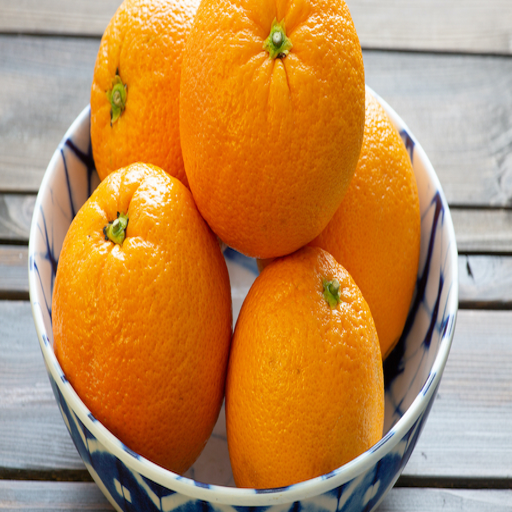

In [19]:
oranges

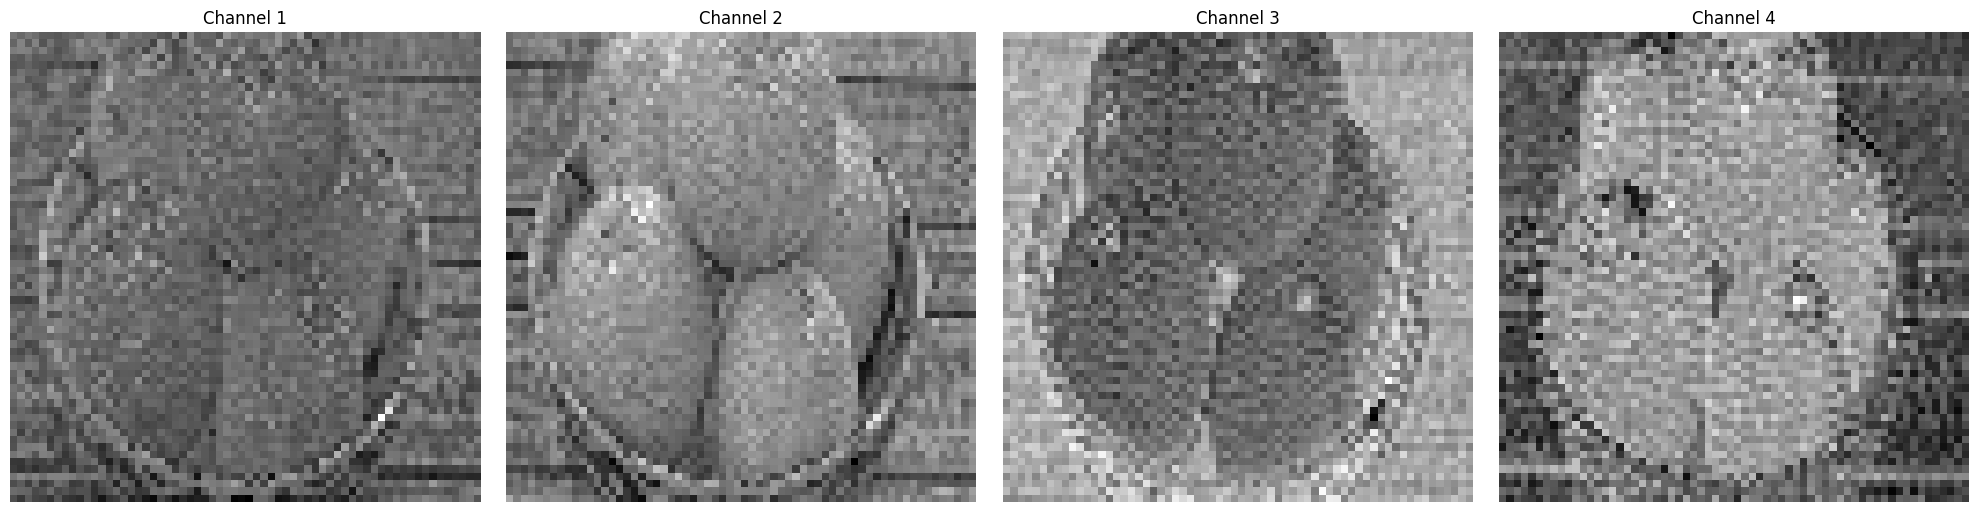

In [21]:
# Generate a mask
im_tensor = transforms.ToTensor()(oranges)
im_tensor = im_tensor.to(device).to(torch.float16)
latents = img_to_latents(im_tensor)
visualize_latents(latents)

  0%|          | 0/10 [00:00<?, ?it/s]

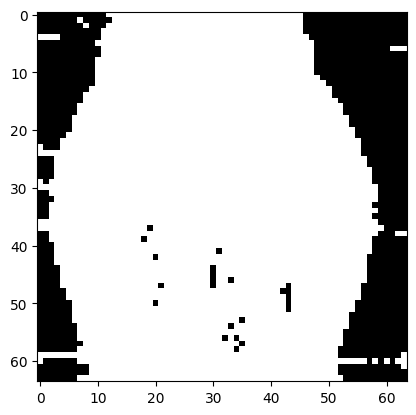

In [24]:
mask = get_mask(latents, 'a bowl of oranges', 'a bowl of berries', threshold = 0.07)
plt.imshow(mask.cpu().detach().numpy(), cmap = 'gray')

  0%|          | 0/46 [00:00<?, ?it/s]

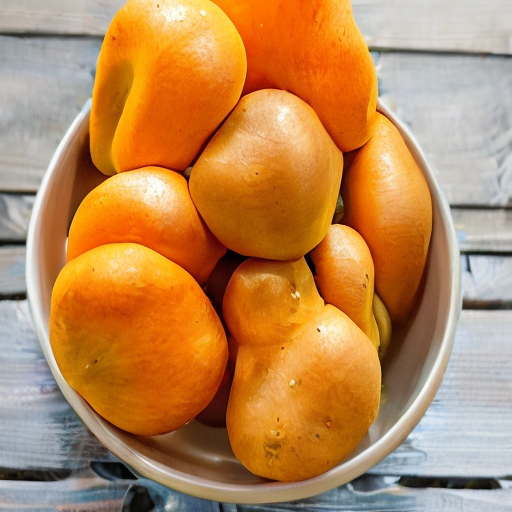

In [31]:
yt = edit_image(latents, mask, 'a bowl full of black mushrooms', strength = 0.35, num_timesteps = 70)
decode_and_visualize(yt)